# Flight Data <code>Exploration Analysis</code>
This data is official flight data (year consisting - (2018-2022)).

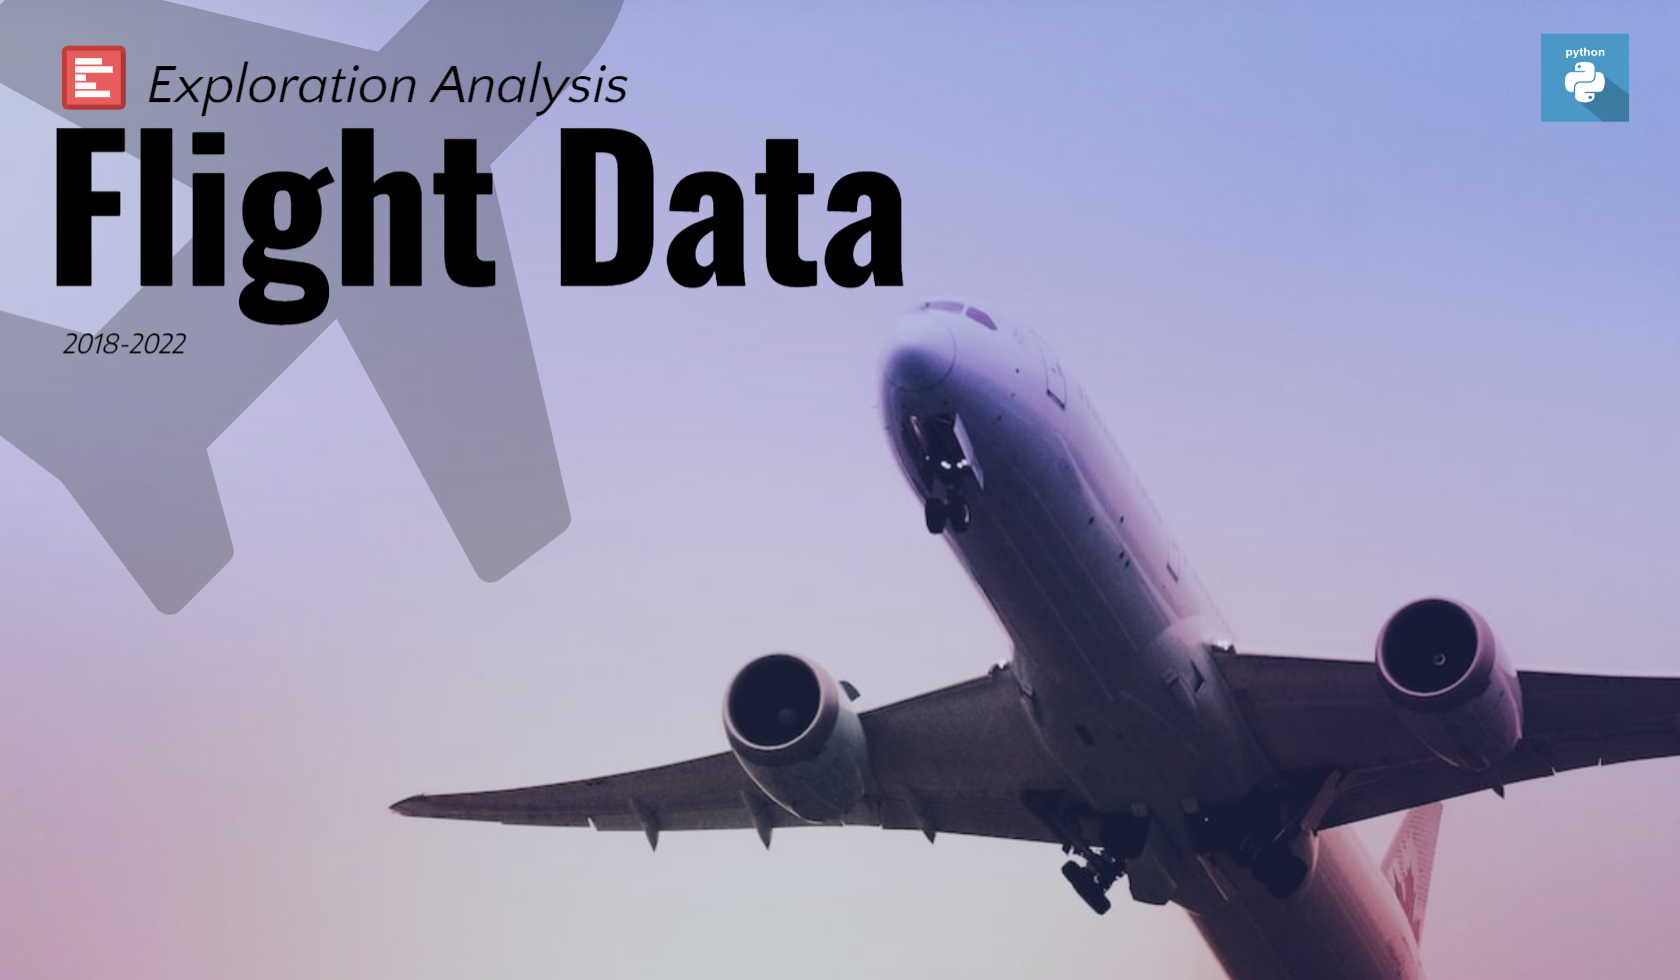

In [2]:
pip install calmap

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import calmap
plt.style.use("seaborn-colorblind")
pal = sns.color_palette("Paired")

<ipython-input-3-9f012ee18cf0>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-colorblind")


# Reading the <code>Clean Data</code>

In [4]:
df = pd.read_parquet('/content/drive/MyDrive/flights_data/flights_df.parquet')

# Flight Departure Delays

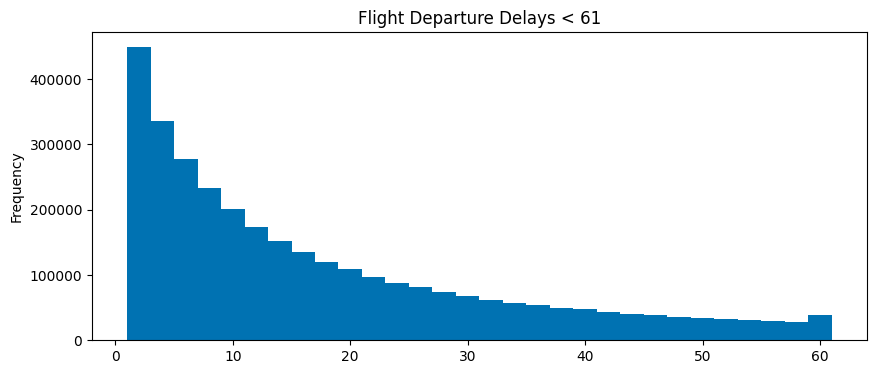

In [5]:
df.query('1 <= DepDelayMinutes <=61')['DepDelayMinutes'].plot(kind = 'hist', bins = 30, title = "Flight Departure Delays < 61", figsize = (10,4))
plt.show()

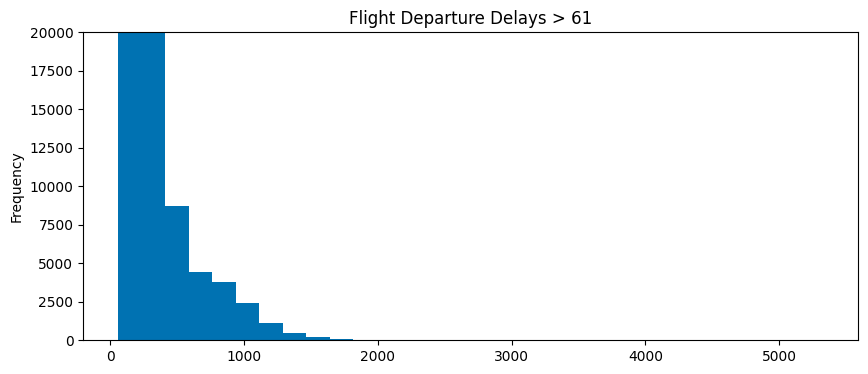

In [6]:
df.query('DepDelayMinutes > 61')['DepDelayMinutes'].plot(kind = 'hist', bins = 30, title = "Flight Departure Delays > 61", figsize = (10,4))
plt.ylim([0, 20000])
plt.show()

# Flight Status

In [7]:
#Create new column in Data Frame
df['DelayGroup'] = None
#Assign groups on the basis of delay Minutes
df.loc[df['DepDelayMinutes'] == 0, 'DelayGroup'] = 'OnTime_Early'
df.loc[(df['DepDelayMinutes'] > 0) & (df['DepDelayMinutes']<=15), 'DelayGroup'] = 'Small_Delay'
df.loc[(df['DepDelayMinutes']>15) & (df['DepDelayMinutes']<=45), 'DelayGroup'] = 'Medium_Delay'
df.loc[(df['DepDelayMinutes']>45), 'DelayGroup'] = 'Large_Delay'
df.loc[(df['Cancelled']), 'DelayGroup'] = 'Cancelled'

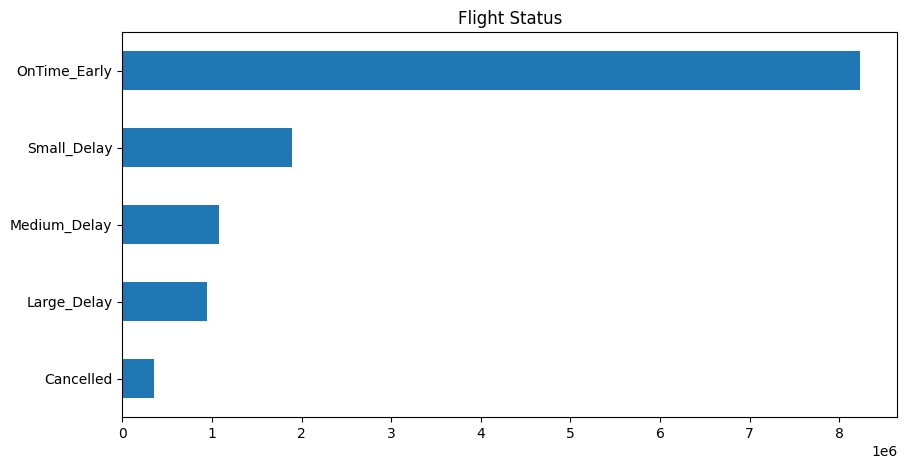

In [8]:
df['DelayGroup'].value_counts(ascending = True).plot(kind = 'barh', title = 'Flight Status',figsize = (10,5), color = pal[1])
plt.show()

# How many <code>Flights Per Year</code> ?

In [9]:
df['Year'] = df['FlightDate'].dt.year

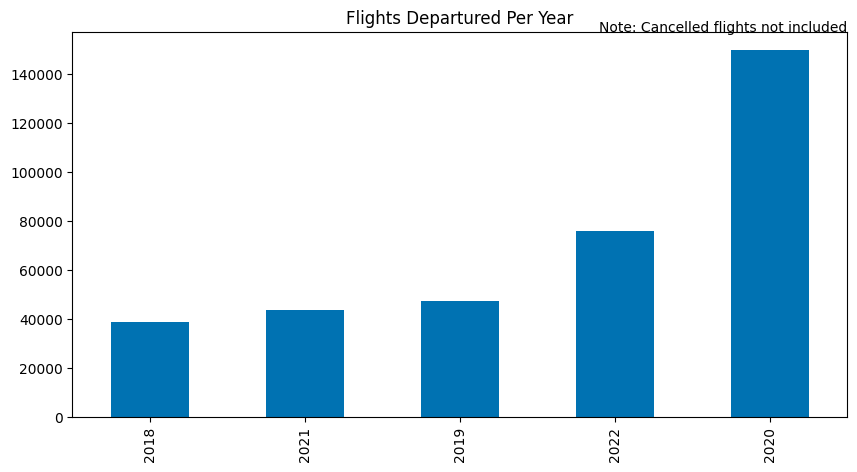

In [10]:
df.query('Cancelled==True')['Year'].value_counts(ascending = True).plot(kind = 'bar', figsize = (10,5), title = 'Flights Departured Per Year')
plt.text(1, 1, 'Note: Cancelled flights not included', horizontalalignment='right', verticalalignment='baseline', transform=plt.gca().transAxes)
plt.show()

# % of <code>Delay</code> Per Year

In [11]:
df_agg = df.groupby('Year')['DelayGroup'].value_counts(normalize = True).unstack() *100
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]
df_agg[col_order].style.background_gradient(cmap="Greens")

DelayGroup,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
Year,,,,,
2018,64.145825,16.456306,9.537664,8.306308,1.553897
2019,64.666560,15.693840,9.088840,8.659960,1.890800
2020,76.045920,9.653480,4.580640,3.731200,5.988760
2021,65.712720,16.143120,8.919520,7.476840,1.747800
2022,58.793760,17.698600,10.924920,9.548960,3.033760


# % of <code>Delay</code> Per Month

In [12]:
df['Month'] = df['FlightDate'].dt.month
dfm_agg = df.groupby('Month')['DelayGroup'].value_counts(normalize = True).unstack() * 100
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]
dfm_agg[col_order].style.background_gradient(cmap = 'Blues')

DelayGroup,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
Month,,,,,
1,67.701359,14.009863,7.954353,7.096331,3.238093
2,65.048136,15.368903,8.794198,7.653600,3.135163
3,65.732300,14.207245,7.845248,6.287442,5.927764
4,63.345591,14.239900,7.994913,6.933244,7.486352
5,64.650974,16.444258,9.121032,7.816406,1.967330
6,59.527540,17.408603,10.761089,10.267015,2.035753
7,62.237153,16.267897,10.090042,9.751922,1.652986
8,65.547675,14.640654,8.864843,8.830332,2.116496
9,73.496652,12.876156,6.587740,5.692834,1.346617


### Visual Insights

#### 1. September, October, November have the highest On Time early Flights.
#### 2. June and July have the lowest on Time early Flights.
#### 3. May, June, July and december have the highest Small flights Delay.
#### 4. June have the highest small flights delay, Medium flights delay and large delay.
#### 5. June, July and August have the highest Large flight delay (More than 45 minutes).
#### 6. November have the lowest Flight Cancellation.
#### 7. March and April have the highest flight cancellation.  

# High Cancellation in <code>March/April</code>? What does it look like by year for these months?

In [13]:
df_ma = (df.query('3 <=Month <= 4').groupby('Year')['DelayGroup'].value_counts(normalize = True).unstack() *100)
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]
df_ma[col_order].style.background_gradient(cmap='YlOrRd')

DelayGroup,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
Year,,,,,
2018,64.292219,17.184280,9.548137,7.290334,1.685030
2019,65.680495,15.591453,8.642873,7.974406,2.110774
2020,63.010082,6.221887,3.292954,2.741366,24.733711
2021,76.218430,13.089907,5.714431,4.087981,0.889251
2022,59.240772,18.229184,11.112226,9.484772,1.933046


### Visual Insights

#### Year <code>2020</code> have the Highest Flight Cancellation because of <code>Covid Virus</code>.
#### Year <code>2021</code> have the Lowest Flight Cancellation because of <code>Lifting Up Lockdown</code>

# Using <code>Calmap</code> to get all Time Flight Data

Text(0.5, 0.94, 'Flight Cancellations')

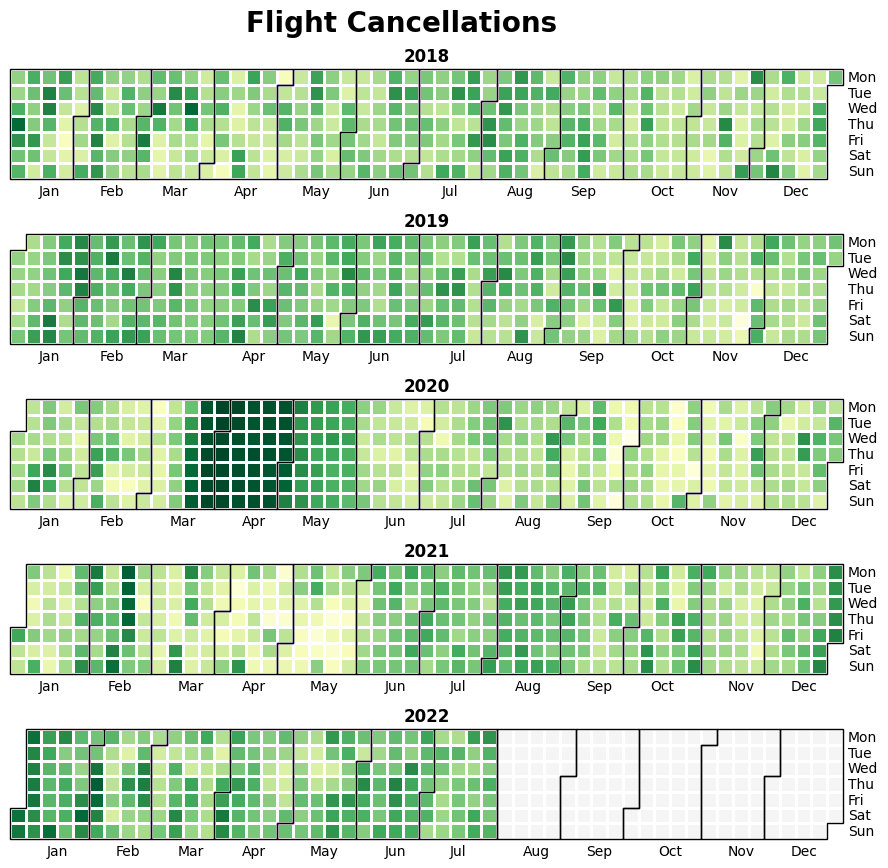

In [14]:
import calmap
events = df.groupby("FlightDate")["Cancelled"].mean()
fig, axs = plt.subplots(5, 1, figsize=(20, 10))
for i, year in enumerate([2018, 2019, 2020, 2021, 2022]):
    calmap.yearplot(
        events.apply(np.log), year=year, cmap='YlGn',linewidth=1, monthly_border=True, ax=axs[i]
    )
    axs[i].set_title(year, fontweight = 'bold')
plt.subplots_adjust(hspace = 0.5)
fig.patch.set_facecolor("white")
fig.suptitle("Flight Cancellations", y=0.94, fontsize=20, fontweight = 'bold')

# interactive Calmap

In [15]:
!pip install calmap plotly_calplot -q

In [16]:
from plotly_calplot import calplot

# creating the plot
fig = calplot(events.apply(np.log).reset_index(), x="FlightDate", y="Cancelled")
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
)
fig.show()

# Compare Airlines
* Who has the most delays?
* Who has the most cancellations?
* Who is the most reliable? (on time) ?

Text(0.5, 0, 'Flights (100k)')

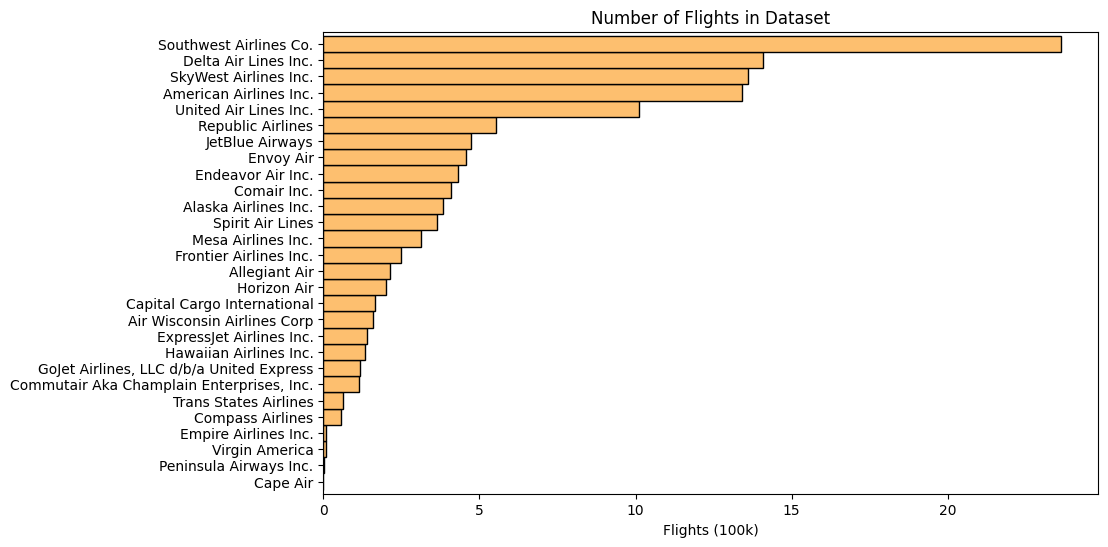

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
airlines_ordered = (df["Airline"].value_counts(ascending=True) / 100_000).plot(
    kind="barh", ax=ax, color=pal[6], width=1, edgecolor="black"
)
ax.set_title("Number of Flights in Dataset")
ax.set_xlabel("Flights (100k)")

# Top 10 Airlines - status

In [18]:
top_airlines = (
    df['Airline']
    .value_counts(ascending = False)
    .reset_index()
    .head()['index']
    .values.tolist()
)

df_top = df.loc[df["Airline"].isin(top_airlines)].reset_index(drop=True).copy()

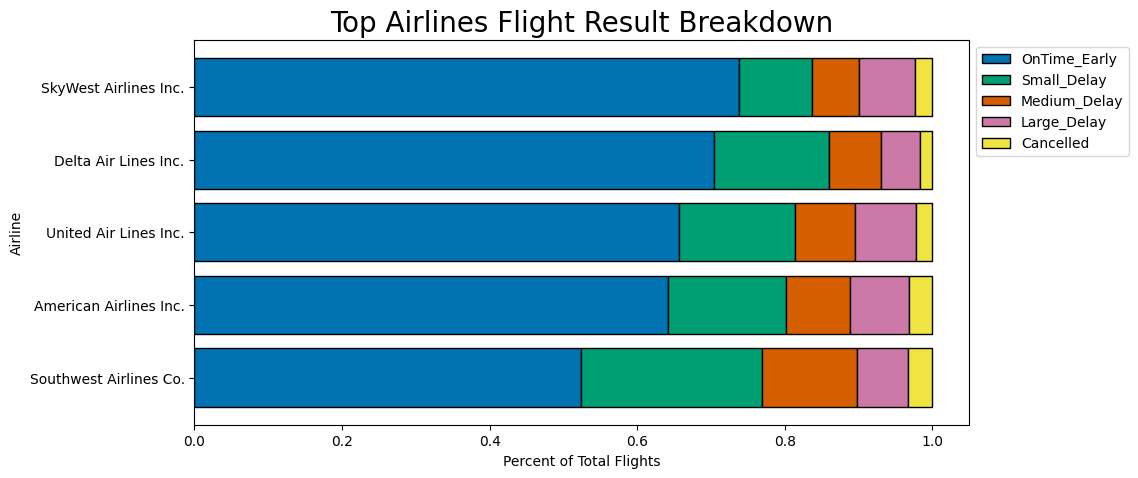

In [36]:
df_top["Airline"] = df_top["Airline"].astype("str").astype("category")

col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]

df_agg = (
    df_top
    .groupby(["Airline"])["DelayGroup"]
    .value_counts(normalize=True)
    .unstack()[col_order]
)

fig, ax = plt.subplots(figsize=(10, 5))
df_agg.sort_values("OnTime_Early").plot(
    kind="barh", stacked=True, ax=ax, width=0.8, edgecolor="black"
)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_title("Top Airlines Flight Result Breakdown", fontsize=20)
ax.set_xlabel("Percent of Total Flights")
plt.show()

# Which Airline is <code>Good</code> and <code>Bad</code>?

In [26]:
delay_mapping = {
    "OnTime_Early": "Good",
    "Small_Delay": "Good",
    "Medium_Delay": "Bad",
    "Large_Delay": "Bad",
    "Cancelled": "Bad",
}

df_top["DelayOk"] = df_top["DelayGroup"].map(delay_mapping)

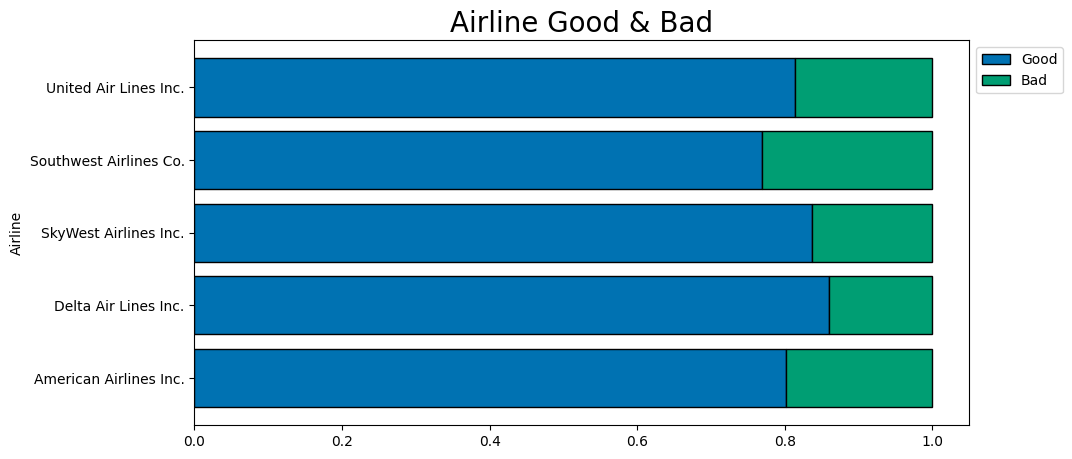

In [39]:
df_agg = df_top.groupby('Airline')['DelayOk'].value_counts(normalize = True).unstack()[["Good", "Bad"]]

fig, ax = plt.subplots(figsize = (10,5))
df_agg.plot(kind = 'barh', stacked = True, ax=ax, width=0.8, edgecolor="black")
ax.legend(bbox_to_anchor=(1, 1))
ax.set_title('Airline Good & Bad', fontsize=20)
plt.show()

### Visual Insights

*   Delta AirLine INC. is good for Travel as compared to other top 5 Airlines.